# Notebook de cliente

In [1]:
from datasets import load_dataset
from model import NERClassifier
from preprocess_dataset import NERDataset 
from trainner import Trainner
from transformers import BertTokenizerFast
from preprocess_dataset import remove_empty_entries

import torch

## Setups

In [2]:
CHECKPOINT = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizerFast.from_pretrained(CHECKPOINT)

In [3]:
data = "lener_br"
dataset = load_dataset(data)
dataset = remove_empty_entries(dataset)

Reusing dataset lener_br (/home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382)
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-5e59bc59f25f3d7f.arrow
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-8d0457760cd67ee6.arrow
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-74e841c1c151996a.arrow


In [4]:
MAX_LEN = 128
n_labels = 13 #TODO: por enquanto hardcodado 

In [5]:
pytorch_dataset_train = NERDataset(data=dataset['train'], max_len=MAX_LEN, tokenizer=tokenizer)
teste = pytorch_dataset_train[0]

In [6]:
model = NERClassifier(n_labels=n_labels, checkpoint=CHECKPOINT)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

----------------------------------------

## Treinando o modelo

Usando parametros padrão por enquanto só pra ver se ta tudo indo certindo

In [7]:
from trainner import Trainner, create_data_loader
from transformers import AdamW
from torch.utils.data import DataLoader

### Parametros


* batch sizes: 8, 16, 32, 64, 128
* learning rates: 3e-4, 1e-4, 5e-5, 3e-5

Do paper do BERT. Vou colocar num_workers = 4 por enquanto.


Uma melhoria é esconder o data_loader de clientes. Isso é detalhe de implementaçãõ, ou deveria estar na classe NERDataset

In [8]:
optimizer = AdamW(model.parameters(), lr=3e-4, correct_bias=False)

In [9]:
len(pytorch_dataset_train)

7827

In [10]:
loader = DataLoader(pytorch_dataset_train, batch_size=8, shuffle=True)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
next(model.parameters()).is_cuda

False

In [13]:
tr = Trainner(device, loader, model, optimizer, max_len=128, num_examples=len(pytorch_dataset_train), num_epochs=1)

In [14]:
%%time
losses, f1 = tr._train_epoch()

Treinando em cuda
Iteração 0 -------- Loss: 2.5245063304901123 f1 nas ultimas 100 iterações: 0.001692532933408846 ------ Progresso: 0.00%.
Iteração 100 -------- Loss: 1.2976526021957397 f1 nas ultimas 100 iterações: 0.7953063325147576 ------ Progresso: 10.21%.
Iteração 200 -------- Loss: 0.36282482743263245 f1 nas ultimas 100 iterações: 0.8245780689375267 ------ Progresso: 20.43%.
Iteração 300 -------- Loss: 1.125670313835144 f1 nas ultimas 100 iterações: 0.8075478375811918 ------ Progresso: 30.64%.
Iteração 400 -------- Loss: 0.8367236256599426 f1 nas ultimas 100 iterações: 0.7981979229451158 ------ Progresso: 40.86%.
Iteração 500 -------- Loss: 0.1903146654367447 f1 nas ultimas 100 iterações: 0.8175964924934246 ------ Progresso: 51.07%.
Iteração 600 -------- Loss: 0.5109924674034119 f1 nas ultimas 100 iterações: 0.8177118153857805 ------ Progresso: 61.29%.
Iteração 700 -------- Loss: 1.2688935995101929 f1 nas ultimas 100 iterações: 0.8266839287876416 ------ Progresso: 71.50%.
Iteraçã

In [15]:
from matplotlib import pyplot as plt

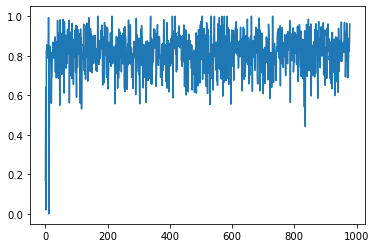

In [16]:
plt.plot(f1)

In [17]:
import numpy as np

In [18]:
np.mean(f1)

0.8145048298178568

Os Losses estão aleatorios, no entanto, o f1 está ótimo. Em media 0.8 na primeira passada é um resultado bem legal. Vou avaliar agora se ele muda entre passadas

## Comparando f1_score ao longo de épocas

## Avaliando o modelo com o conjunto de dados de teste

In [19]:
pytorch_dataset_test = NERDataset(data=dataset['test'], max_len=MAX_LEN, tokenizer=tokenizer)

In [20]:
ds_test = DataLoader(pytorch_dataset_test, batch_size=8, shuffle=True)

In [21]:
import evaluator

In [22]:
from importlib import reload

In [23]:
reload(evaluator)

<module 'evaluator' from '/home/caiotulio/MAC0499/model/evaluator.py'>

In [24]:
l_eval, f1_eval = evaluator.evaluate(model, ds_test, 'cuda')

Iteração 100 -------- Loss: 0.5572746992111206 f1 nas ultimas 100 iterações: 0.8456629048662913 ------ Progresso: 57.47%.


In [25]:
np.mean(l_eval)

0.5655802151766317

In [26]:
np.mean(f1_eval)

0.8398123952855756

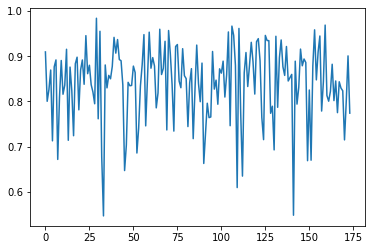

In [27]:
plt.plot(f1_eval)